<a href="https://colab.research.google.com/github/rahiakela/advanced-deep-learning-with-tensorflow-2-and-keras/blob/3-autoencoders/automatic_image_colorization_using_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic image colorization using autoencoder

We're going to imagine that we have a grayscale photo and that we want to
build a tool that will automatically add color to it. We would like to replicate the human abilities in identifying that the sea and sky are blue, the grass field and trees are green, while the clouds are white, and so on.

<img src='https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter3-autoencoders/images/gray_color_mayon.png?raw=1' width='800'/>

As shown, if we are given a grayscale photo (left) of a rice field in
the foreground, a volcano in the background, and sky on the top, we're able to add the appropriate colors (right).

A simple automatic colorization algorithm seems like a suitable problem for
autoencoders. If we can train the autoencoder with a sufficient number of grayscale photos as input and the corresponding colored photos as output, it could possibly discover the hidden structure on properly applying colors. Roughly, it is the reverse process of denoising. The question is, can an autoencoder add color (good noise) to the original grayscale image?

## Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from tensorflow.keras.datasets import cifar10

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Convert RGB image to Grayscal

Firstly, we need a dataset of grayscale to colored photos. The CIFAR10 database, has 50,000 training and 10,000 testing 32 × 32 RGB photos that can be converted to grayscale.

In [0]:
def rgb2gray(rgb):
  """
  Convert from color image (RGB) to grayscale.
  grayscale = 0.299*red + 0.587*green + 0.114*blue
  Argument:
    rgb (tensor): rgb image
  Return:
    (tensor): grayscale image
  """
  return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

In [5]:
dataset = keras.utils.get_file('cifar-10-python.tar.gz', origin='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')

170500096/170498071 [==============================] - 4s 0us/step


In [6]:
# load the CIFAR10 data
(x_train, _), (x_test, _) = cifar10.load_data()
x_train.shape

170500096/170498071 [==============================] - 4s 0us/step


(50000, 32, 32, 3)

In [7]:
# input image dimensions, we assume data format "channels_last"
img_rows = x_train.shape[1]
img_cols  = x_train.shape[2]
channels = x_train.shape[3] 

# create saved_images folder
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)
save_dir

'/content/saved_images'

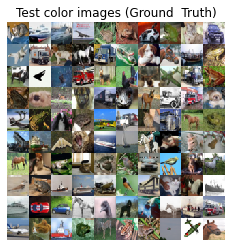

In [8]:
# display the 1st 100 input images (color and gray)
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

In [0]:
# convert color train and test images to gray
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

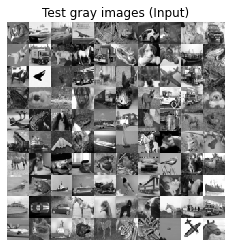

In [10]:
# display grayscale version of test images
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

## Image preprocessing

In [0]:
# normalize output train and test color images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#  normalize input train and test grayscale images
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

# reshape color images to row x col x channel for CNN output/validation
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

# reshape grayscale images to row x col x channel for CNN input
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

## Colorization autoencoder network

The colorization autoencoder network is a modified version of the denoising autoencoder.

In [0]:
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256

# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

First build the encoder model

In [13]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='SAME')(x)

'''
shape info needed to build decoder model so we don't do hand computation
the input to the decoder's first Conv2DTranspose will have this shape
shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
'''
shape = K.int_shape(x)

# generate a latent vector
x = Flatten()(x)
latent_vector = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent_vector, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________

Then build the decoder model.

In [14]:
latent_inputs = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='SAME')(x)

outputs = Conv2DTranspose(filters=channels, kernel_size=kernel_size, activation='sigmoid', padding='SAME', name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              1052672   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         1731

Now, build the autoencoder model that should be:
$$autoencoder = encoder + decoder$$

In [15]:
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 256)               1418496   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


Prepare model saving directory.

Epoch 1/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0152
Epoch 00001: val_loss improved from inf to 0.01094, saving model to /content/saved_models/colorized_ae_model.001.h5
1563/1563 [==============================] - 21s 14ms/step - loss: 0.0152 - val_loss: 0.0109 - lr: 0.0010
Epoch 2/30
1562/1563 [============================>.] - ETA: 0s - loss: 0.0100
Epoch 00002: val_loss improved from 0.01094 to 0.00934, saving model to /content/saved_models/colorized_ae_model.002.h5
1563/1563 [==============================] - 21s 13ms/step - loss: 0.0100 - val_loss: 0.0093 - lr: 0.0010
Epoch 3/30
1559/1563 [============================>.] - ETA: 0s - loss: 0.0091
Epoch 00003: val_loss improved from 0.00934 to 0.00867, saving model to /content/saved_models/colorized_ae_model.003.h5
1563/1563 [==============================] - 21s 13ms/step - loss: 0.0091 - val_loss: 0.0087 - lr: 0.0010
Epoch 4/30
1562/1563 [============================>.] - ETA: 0s - loss: 0.0085
Epoch 0000

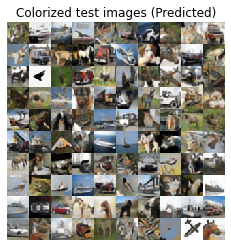

In [17]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'

if not os.path.isdir(save_dir):
  os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, verbose=1, min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True)

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# called every epoch
callbacks = [lr_reducer, checkpoint]

# train the autoencoder
autoencoder.fit(x_train_gray, x_train, validation_data=(x_test_gray, x_test), epochs=30, batch_size=batch_size, callbacks=callbacks)

# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)

# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')

plt.show()

The colorization autoencoder is now trained with the grayscale as inputs and
original RGB images as outputs. The training will take more epochs and uses the
learning rate reducer to scale down the learning rate when the validation loss is not improving.

The autoencoder performs an acceptable colorization job. The sea or sky is predicted to be blue, animals have varying shades of brown, the cloud is white, and so on.

There are some noticeable incorrect predictions, such as red vehicles have become blue or blue vehicles have become red, and the occasional green field has been mistaken as blue skies, and dark or golden skies are converted into blue skies.
